In [1]:
!nvidia-smi

Thu Sep 21 20:23:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
torch.cuda.is_available()

True

## Download CRE Stereo code

In [1]:
!git clone https://github.com/megvii-research/CREStereo.git

Cloning into 'CREStereo'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 80 (delta 26), reused 53 (delta 9), pack-reused 0
Receiving objects: 100% (80/80), 3.71 MiB | 8.32 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
!pip install -r CREStereo/requirements.txt

## Generate left disparity map

In [47]:
!python3 CREStereo/test.py --model CREStereo/crestereo_eth3d.mge --left CREStereo/img/test/roses_L.png --right CREStereo/img/test/roses_R.png --size 500x338 --output left_disparity.png
!mv left_disparity.png CREStereo/img/test/roses_left_disparity.png


Loading model: /content/CREStereo/crestereo_eth3d.mge
Images resized: 500x338
Model Forwarding...
Done! Result path: /content/left_disparity.png


## Generate right disparity map

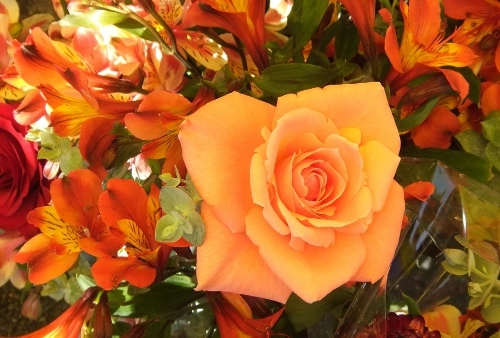

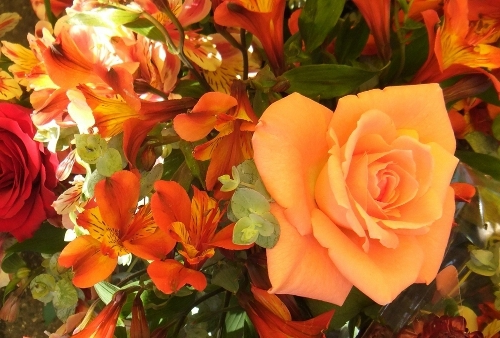

Loading model: /content/CREStereo/crestereo_eth3d.mge
Images resized: 500x338
Model Forwarding...
Done! Result path: /content/right_disparity_rotated.png


In [54]:
# !pip install opencv-python

import cv2
from google.colab.patches import cv2_imshow

'''
Rotate left and right disparity maps
'''
left_img = cv2.imread("CREStereo/img/test/roses_L.png")
rotated_left_img = left_img[:, ::-1]
# cv2_imshow(rotated_left_img)
cv2.imwrite("roses_L_rotated.png", rotated_left_img)

right_img = cv2.imread("CREStereo/img/test/roses_R.png")
rotated_right_img = right_img[:, ::-1]
# cv2_imshow(rotated_right_img)
cv2.imwrite("roses_R_rotated.png", rotated_right_img)

!mv roses_R_rotated.png CREStereo/img/test/roses_R_rotated.png
!mv roses_L_rotated.png CREStereo/img/test/roses_L_rotated.png

'''
Generate rotated version of right disparity map
'''
!python3 CREStereo/test.py --model CREStereo/crestereo_eth3d.mge --left CREStereo/img/test/roses_R_rotated.png --right CREStereo/img/test/roses_L_rotated.png --size 500x338 --output right_disparity_rotated.png


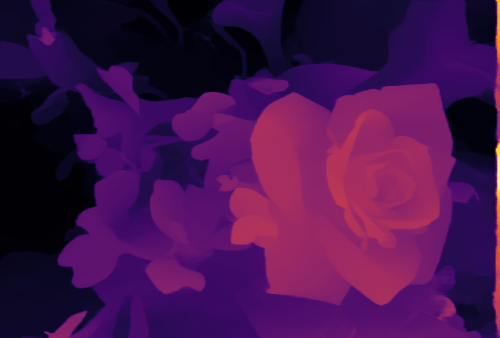

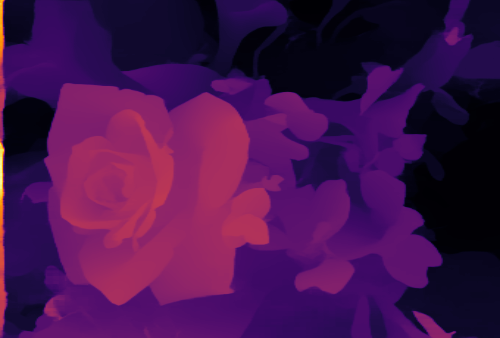

In [57]:
'''
Correct orientation of right disparity map
'''
right_disp_rotated = cv2.imread("right_disparity_rotated.png")
cv2_imshow(right_disp_rotated)
right_disp = right_disp_rotated[:, ::-1]
cv2_imshow(right_disp)
cv2.imwrite("roses_right_disparity.png", right_disp)

!mv roses_right_disparity.png CREStereo/img/test/roses_right_disparity.png

## Convert disparity maps to grayscale

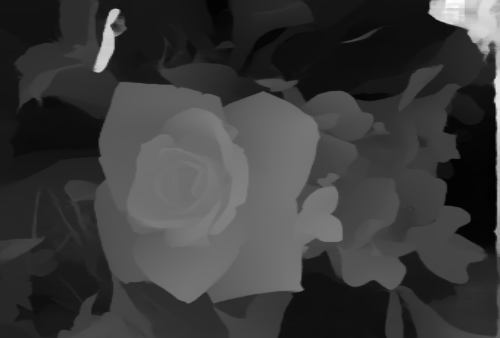

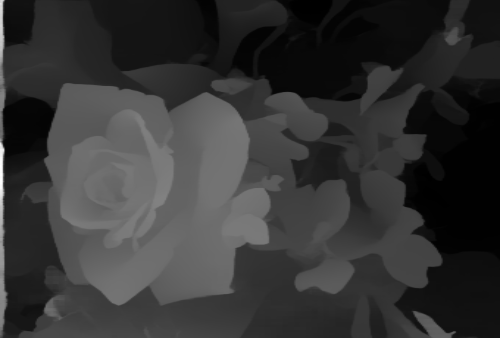

In [59]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def convertRgbToGrayscale(color_image, side):
    # This solution is based on
    # https://stackoverflow.com/questions/51824718/opencv-jetmap-or-colormap-to-grayscale-reverse-applycolormap
    # create an inverse from the colormap to gray values
    gray_values = np.arange(256, dtype=np.uint8)
    color_values = map(tuple, cv2.applyColorMap(gray_values, cv2.COLORMAP_INFERNO).reshape(256, 3))
    color_to_gray_map = dict(zip(color_values, gray_values))

    # apply the inverse map to the false color image to reconstruct the grayscale image
    gray_image = np.apply_along_axis(lambda bgr: color_to_gray_map[tuple(bgr)], 2, color_image)

    # save reconstructed grayscale image
    cv2.imwrite(f'grayscale_disp_map_{side}.png', gray_image)
    return gray_image

disp = cv2.imread("CREStereo/img/test/roses_left_disparity.png", cv2.IMREAD_UNCHANGED)
left_disp_gray = convertRgbToGrayscale(disp, "left")

cv2_imshow(left_disp_gray)

disp = cv2.imread("CREStereo/img/test/roses_right_disparity.png", cv2.IMREAD_UNCHANGED)
right_disp_gray = convertRgbToGrayscale(disp, "right")

cv2_imshow(right_disp_gray)